# **Imports**

In [ ]:
# Uncoment to install requirements

#!git clone 'https://github.com/alok-ai-lab/pyDeepInsight'
#!pip install -r requirements.txt
#!python3 -m pip -q install git+https://github.com/alok-ai-lab/pyDeepInsight

In [ ]:
# Cd to the directory where DeepInsight is installed

cd '.../DeepInsight/pyDeepInsight/pyDeepInsight/' \


In [ ]:
import pickle
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.ticker as ticker
import seaborn as sns

from image_transformer import ImageTransformer, LogScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

#**Helper Functions**

In [ ]:
def quality(fdm, total_features):
    """
    Calculate the quality metrics from a given feature density matrix.

    Args:
        fdm (array-like): The feature density matrix.
        total_features (int): The total number of features in the dataset.

    Returns:
        tuple: 4 tuples containing the metrics:
            - overlapped_features_percent (float): The percentage of overlapped features.
            - overlapped_pixels_percent (float): The percentage of pixels that contain overlapped features.
            - overlapped_features (int): The count of overlapped features.
            - overlapped_pixels (int): The count of pixels that contain overlapped features.

    Note: The function requires numpy functions to perform the calculations efficiently.
    """
    overlapped_features = np.sum(fdm[fdm > 1])

    overlapped_features_percent = (overlapped_features / total_features) * 100
    overlapped_pixels_percent = (np.count_nonzero(fdm > 1) / np.size(fdm)) * 100

    return overlapped_features_percent, overlapped_pixels_percent, overlapped_features, np.count_nonzero(fdm)

def plot_metrics(dr_algorithms, px_sizes, ov_metrics, title, xlabel, ylabel, ylim=None, plot_size=(15, 15)):
    """
    Plot the metrics for different dimensionality reduction (DR) algorithms.

    Args:
        dr_algorithms (list): List of algorithm string names, or a DR that contains a 'fit_transform' method.
        px_sizes (list): List of matrix sizes.
        ov_metrics (dict): Dictionary containing the quality metrics for each algorithm.
        title (str): The title of the plot.
        xlabel (str): The label for the x-axis.
        ylabel (str): The label for the y-axis.
        ylim (tuple, optional): The y-axis limits (default is None).
        plot_size (tuple, optional): The size of the plot figure (default is (15, 15)).

    Returns:
        None

    Note: The function uses matplotlib to create the plot and assumes that it is imported as `plt`.
    """
    fig, ax = plt.subplots(figsize=plot_size)

    for alg in dr_algorithms:
        ax.plot(px_sizes, ov_metrics[alg], label=alg)

    ax.set_title(title)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.legend(loc='upper right')
    plt.xticks(px_sizes, rotation=90)

    if ylim is not None:
        plt.ylim(ylim)

    plt.show()

    return None

def conversion_quality_analysis(data, max_image_size=50, dr_algorithms=['tsne', 'pca', 'kpca'], plot=False, plot_size=None, random_state=1701):
    """
    Perform conversion quality analysis on a given dataset using different dimensionality reduction algorithms.

    Args:
        data (array-like): The input dataset for the analysis.
        max_image_size (int, optional): The maximum size of the generated images (default is 50).
        dr_algorithms (list, optional): The dimensionality reduction algorithms to evaluate (default is ['tsne', 'pca', 'kpca']).
        plot (bool, optional): Flag indicating whether to plot the quality metrics (default is False).
        plot_size (tuple, optional): The size of the plot (default is None).
        random_state (int, optional): The random state for the dimensionality reduction algorithm (default is 1701).

    Returns:
        pandas.DataFrame: A summary table containing the minimum feature and pixel overlap metrics for each dimensionality reduction algorithm.

    Raises:
        ValueError: If `plot` is True but `plot_size` is not provided.

    Description:
        This function performs conversion quality analysis on a given dataset using different dimensionality reduction algorithms.
        It calculates the overlap metrics (percentage of overlapped features and percentage of pixels that contain overlapped features)
        for each algorithm and generates a summary table with the minimum values. Optionally, it can also plot the metrics.

        The function takes the following arguments:
        - data: The input dataset for the analysis.
        - max_image_size: The maximum size of the feature density matrix (default is 50).
        - dr_algorithms: The dimensionality reduction algorithms to evaluate (default is ['tsne', 'pca', 'kpca']).
        - plot: Flag indicating whether to plot the metrics (default is False).
        - plot_size: The size of the plot (default is None).

        The function returns a pandas DataFrame containing the minimum feature and pixel overlap metrics for each algorithm.

        If `plot` is set to True, the function will generate two plots showing the percentage of overlapped features and
        the percentage of pixels that contain overlapped features for each algorithm. The `plot_size` parameter must be provided
        when `plot` is True, otherwise a ValueError will be raised.

        Note: The function relies on the `ImageTransformer` and `quality` functions to calculate the feature density matrix
        and the overlap metrics, respectively.
    """
    px_sizes = list(range(2, max_image_size + 1))

    ov_features_p = {alg: [] for alg in dr_algorithms}
    ov_pixels_p = {alg: [] for alg in dr_algorithms}
    ov_features = {alg: [] for alg in dr_algorithms}
    ov_pixels = {alg: [] for alg in dr_algorithms}

    for alg in dr_algorithms:
        it = ImageTransformer(feature_extractor=alg, pixels=max_image_size, random_state=random_state, n_jobs=-1)
        it.fit(data, plot=False)

        for i in px_sizes:
            it.pixels = i
            fdm = it.feature_density_matrix()
            fdm[fdm == 0] = np.nan
            of, op, f, p = quality(fdm, data.shape[1])

            ov_features_p[alg].append(of)
            ov_pixels_p[alg].append(op)
            ov_features[alg].append(f)
            ov_pixels[alg].append(p)

    min_features = {alg: np.min(ov_features_p[alg]) for alg in dr_algorithms}
    min_pixels = {alg: np.min(ov_pixels_p[alg]) for alg in dr_algorithms}
    min_sizes = {alg: px_sizes[np.argmin(ov_features_p[alg])] for alg in dr_algorithms}

    if plot:
        if plot_size is None:
            raise ValueError("Variable graph_img_size must be provided when plot_metrics=True.")

        plot_metrics(dr_algorithms, px_sizes, ov_features_p,
                     f"Percentage of Overlapped Features by Matrix Size Up to {max_image_size}",
                     "Matrix Size",
                     "Percentage",
                     ylim=(0, max(np.max(ov_features_p[alg]) for alg in dr_algorithms) + 2),
                     plot_size=plot_size)

        plot_metrics(dr_algorithms, px_sizes, ov_pixels_p,
                     f"Percentage of Pixels that Contain Overlapped Features by Matrix Size Up to {max_image_size}",
                     "Matrix Size",
                     "Percentage",
                     ylim=(0, max(np.max(ov_pixels_p[alg]) for alg in dr_algorithms) + 2),
                     plot_size=plot_size)

    summary = pd.DataFrame({'Min OF%': min_features.values(),
                            'Min OP%': min_pixels.values(),
                            'Matrix Size': [f"{size}x{size}" for size in min_sizes.values()]},
                            index=min_features.keys())

    print(f"Minimum feature and pixel overlap in a matrix up to {max_image_size}:\n")
    print(summary)

    return summary

def feature_density_matrix(data, dr='tsne', size=50, random_state=1701):

  it = ImageTransformer(feature_extractor=dr, pixels=size, random_state=random_state, n_jobs=-1)
  it.fit(data, plot=False)

  fdm = it.feature_density_matrix()
  fdm[fdm == 0] = np.nan

  plt.figure(figsize=(5, 5))
  plt.xticks(rotation=90)

  ax = sns.heatmap(fdm, cmap="viridis", linewidths=0.01,
                  linecolor="lightgrey", square=True, vmin=1)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(5))

  for _, spine in ax.spines.items():
      spine.set_visible(True)
  _ = plt.title("Features per pixel")

  return None

## Arbo-Inconclusive

In [ ]:
X_train = pd.read_csv('/content/drive/MyDrive/projeto_arbovirose/Leo/Tabular data sets/Arboviruses/Arbo-Inconclusive/X_train.csv', sep=';')
X_test = pd.read_csv('/content/drive/MyDrive/projeto_arbovirose/Leo/Tabular data sets/Arboviruses/Arbo-Inconclusive/X_test.csv', sep=';')

y_train = pd.read_csv('/content/drive/MyDrive/projeto_arbovirose/Leo/Tabular data sets/Arboviruses/Arbo-Inconclusive/y_train.csv', sep=';')
y_test = pd.read_csv('/content/drive/MyDrive/projeto_arbovirose/Leo/Tabular data sets/Arboviruses/Arbo-Inconclusive/y_train.csv', sep=';')

In [ ]:
shapes = pd.DataFrame(
    {

      "Train": [X_train.shape, y_train.shape],
      "Test": [X_test.shape, y_test.shape],
    }, index=['x', 'y']
)

shapes

,Train,Test
x,"(8013, 26)","(3435, 26)"
y,"(8013, 1)","(8013, 1)"


## Dengue-Chikungunya

In [ ]:
X_train = pd.read_csv('/content/drive/MyDrive/Leo/Tabular data sets/Arboviruses/Dengue-Chikungunya/X_train.csv', sep=';')
X_test = pd.read_csv('/content/drive/MyDrive/Leo/Tabular data sets/Arboviruses/Dengue-Chikungunya/X_test.csv', sep=';')

y_train = pd.read_csv('/content/drive/MyDrive/Leo/Tabular data sets/Arboviruses/Dengue-Chikungunya/y_train.csv', sep=';')
y_test = pd.read_csv('/content/drive/MyDrive/Leo/Tabular data sets/Arboviruses/Dengue-Chikungunya/y_test.csv', sep=';')

In [ ]:
shapes = pd.DataFrame(
    {

      "Train": [X_train.shape, y_train.shape],
      "Test": [X_test.shape, y_test.shape],
    }, index=['x', 'y']
)

shapes

## Multiclass

In [ ]:
X_train = pd.read_csv("/content/drive/MyDrive/projeto_arbovirose/Leo/raw_data/raw_multiclass_dataset/train/multiclass_x_train.csv", sep=';')
X_test = pd.read_csv('/content/drive/MyDrive/projeto_arbovirose/Leo/raw_data/raw_multiclass_dataset/test/multiclass_x_test.csv', sep=';')

y_train = pd.read_csv("/content/drive/MyDrive/projeto_arbovirose/Leo/raw_data/raw_multiclass_dataset/labels/multiclass_y_train.csv", sep=';')
y_test = pd.read_csv("/content/drive/MyDrive/projeto_arbovirose/Leo/raw_data/raw_multiclass_dataset/labels/multiclass_y_test.csv", sep=';')

# Saving original labels to dump into the pickle file
y_train_ = y_train
y_test_ = y_test

# **DeepInsight**

In [ ]:
# Import your data set already splitted into training and testing sets as a pandas DataFrame

X_train = X_train = pd.read_csv('X_train.csv', sep=';')
X_test = X_train = pd.read_csv('X_test.csv', sep=';')

## Conversion Quality Analysis (CQA)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA

# Normalize using log scaler

ln = LogScaler()
X_train_norm = ln.fit_transform(X_train)
X_test_norm = ln.transform(X_test)

seed = 1701

# Initialize dimentionalisty reduction algorithms

tsne = TSNE(
      n_components=2,
      perplexity=25,
      metric='cosine',
      random_state=seed,
      n_jobs=-1)

pca = PCA(
    n_components=2,
    random_state=seed)

kpca = KernelPCA(
    n_components=2,
    kernel='rbf',
    random_state=seed,
    n_jobs=-1)

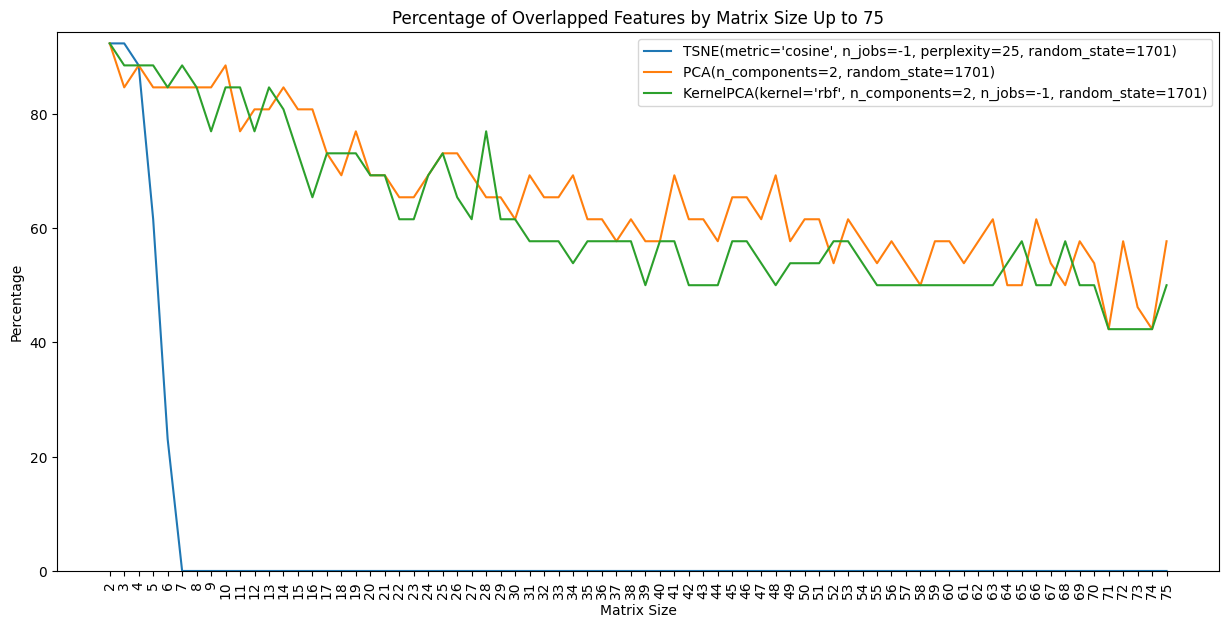

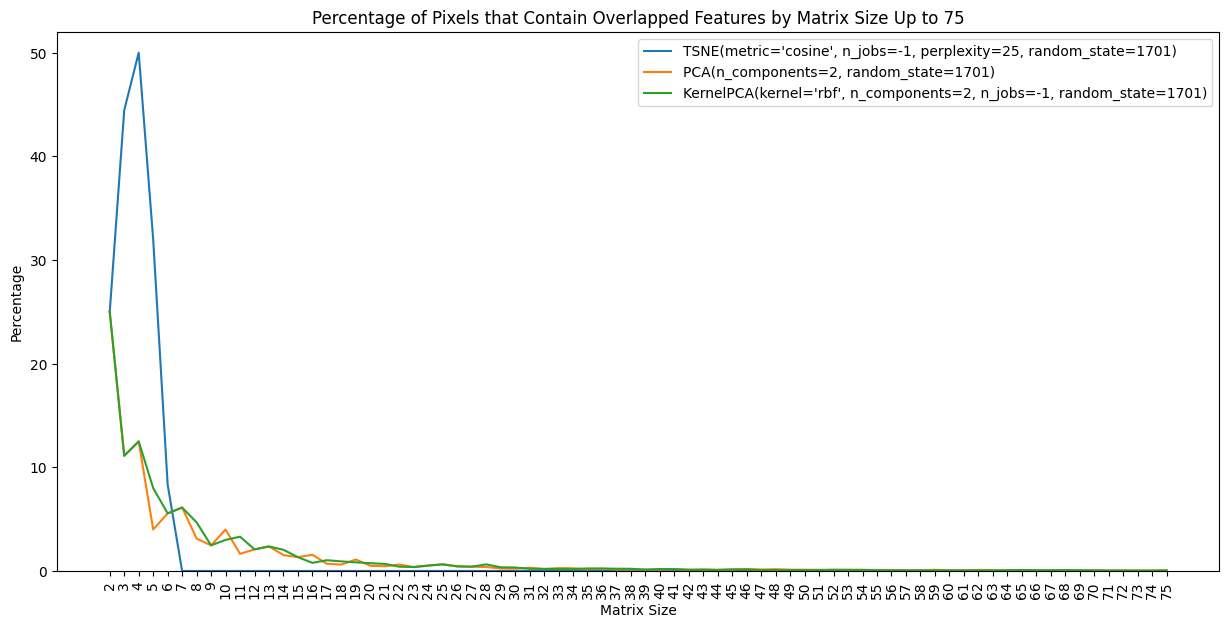

Minimum feature and pixel overlap in a matrix up to 75:

                                                      Min OF%   Min OP%  \
TSNE(metric='cosine', n_jobs=-1, perplexity=25,...   0.000000  0.000000   
PCA(n_components=2, random_state=1701)              42.307692  0.036523   
KernelPCA(kernel='rbf', n_components=2, n_jobs=...  42.307692  0.036523   

                                                   Matrix Size  
TSNE(metric='cosine', n_jobs=-1, perplexity=25,...         7x7  
PCA(n_components=2, random_state=1701)                   71x71  
KernelPCA(kernel='rbf', n_components=2, n_jobs=...       71x71  


In [ ]:
# Choose a list of DR algorithms and a random state
dr_algorithms = [tsne, pca, kpca]
random_state = seed

# Run the CQA
summary = conversion_quality_analysis(X_train_norm, 75, dr_algorithms, plot=True, plot_size=(15, 7))

In [ ]:
summary

,Min OF%,Min OP%,Matrix Size
"TSNE(metric='cosine', n_jobs=-1, perplexity=25, random_state=1701)",0.000000,0.000000,7x7
"PCA(n_components=2, random_state=1701)",42.307692,0.036523,71x71
"KernelPCA(kernel='rbf', n_components=2, n_jobs=-1, random_state=1701)",42.307692,0.036523,71x71


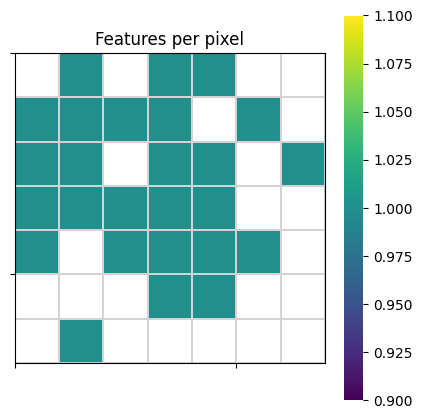

In [ ]:
data = X_train_norm

feature_density_matrix(data, dr=tsne, size=7, random_state=seed)

## Convert data set using the DeepInsight

In [ ]:
# (Optional). Import and convert data set labels to int
y_train = pd.read_csv('y_train.csv', sep=';')
y_test = pd.read_csv('y_test.csv', sep=';')

y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [ ]:
# Fit the training data
it = ImageTransformer(feature_extractor=tsne, pixels=7, random_state=random_state, n_jobs=-1)
it.fit(X_train_norm, plot=False)

X_train_img = it.fit_transform(X_train_norm)

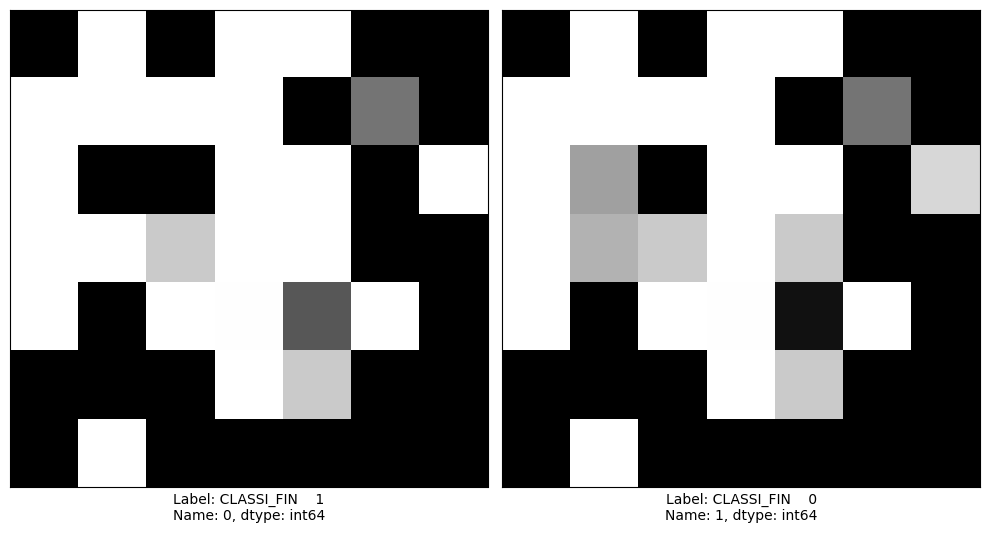

In [ ]:
# Visualize some samples, if you imported the labels uncomment line 8
c = 2

fig, ax = plt.subplots(1, c, figsize=(10, 10))

for i in range(0, c):
    ax[i].imshow(X_train_img[i])
    #ax[i].set_xlabel("Label: {}".format(y_train.iloc[i]))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()

In [ ]:
# Fit testing data set
X_test_img = it.transform(X_test_norm)

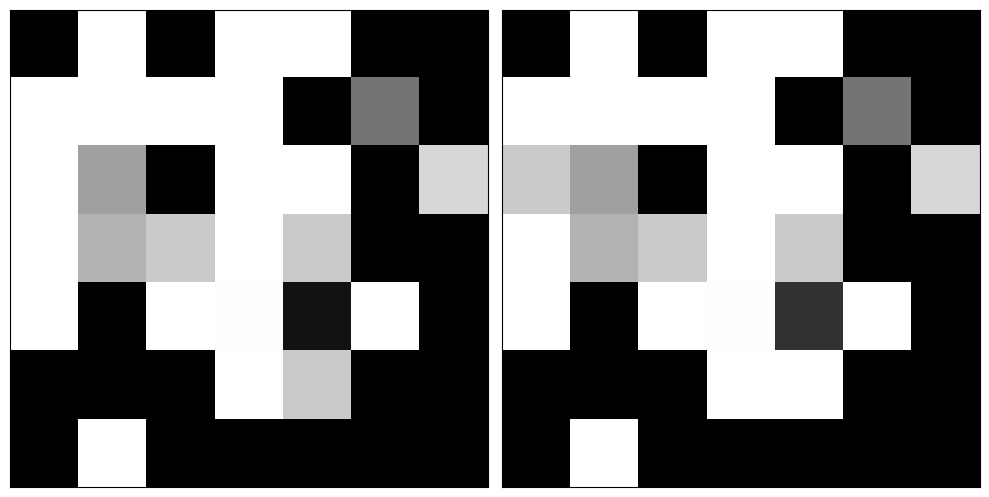

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(X_train_img[1])
#ax[0].set_xlabel("Label: {}".format(y_train.iloc[1]))
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(X_train_img[2])
#ax[1].set_xlabel("Label: {}".format(y_train.iloc[2]))
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.tight_layout()

# **Save**

In [ ]:
# Saving the dataset as a pickle file, can't save image datasets as dataframes it must be a 2d input

dir = '.../DeepInsight/Datasets/Syphilis/'

dataset = 'data.pkl'

with open(dir + dataset, 'wb') as file:
  pickle.dump(X_train_img, file)
  pickle.dump(X_test_img, file)